# k-평균 군집화분석 + 그래프 : 타깃마케팅을 위한 소비자 군집 분석

### 핵심 개념
    비지도학습
        정답이 없다 - 타깃이 없다
    군집화
        데이터를 클러스터(군집)로 구성하는 작업
    K-평균 알고리즘
        K개의 중심점을 임의로 위치로 잡고 중심점을 기준으로 가까이 있는 데이터를 확인 거리(유클리디안 거리) 평균 지점으로 이동
    엘보 방법
        왜곡 : 클러스터 중심점 클러스터내의 데이터의 거리 차이의 제곱의 합
        왜곡의 변화를 그래프로 그려보면 엘보 형태로 나타나고 그 지점이 최적의 K 개수
    실루엣 분석
        클러스터내에서 데이터가 얼마나 조밀하게 모여 있는지 측정하는 도구
        데이터 : i
        응집력 a(i) : 데이터 i가 해당 클러스터내에서 데이터와 얼마나 가까운가를 나타냄
        분리도 b(i) : 가장 가까운 다른 클러스터내의 데이터와 얼마나 떨어져 있는지를 나타내는 지수
        실루엣 계수 s(i) : -1 ~ 1 가지고 1에 가까울 수록 좋은 군집화
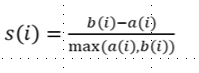        

In [1]:
filepath = './Online Retail.xlsx'
import pandas as pd
import numpy as np

In [2]:
retail_df = pd.read_excel(filepath)
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [4]:
# retail_df['InvoiceNo'] 에서 숫자가 아닌 항목들 찾기
for i in retail_df['InvoiceNo']:
    if(not type(i) == int):
        print(i)
        break

C536379


In [5]:
#  InvoiceNo  C가 붙어 있으면 주문 취소

# 데이터 전처리
    결측치 처리
    이상치 처리
    타입을 통일
    스케일 조정
    중복데이터 제거
    - CustomerID는 정수형태  자료형을 정수형 
    - CustomerID가 없으면 제거,  Quantity UnitPrice 수량과 가격은 양수만 존재해야 함 그래서 혹시 음수가 있으면 제거

In [6]:
retail_df =  retail_df[retail_df['Quantity'] > 0]
retail_df =  retail_df[retail_df['UnitPrice'] > 0]

In [7]:
retail_df.isnull().mean()

InvoiceNo      0.000000
StockCode      0.000000
Description    0.000000
Quantity       0.000000
InvoiceDate    0.000000
UnitPrice      0.000000
CustomerID     0.249423
Country        0.000000
dtype: float64

In [8]:
retail_df.dropna(inplace=True)

In [9]:
retail_df.isnull().mean()

InvoiceNo      0.0
StockCode      0.0
Description    0.0
Quantity       0.0
InvoiceDate    0.0
UnitPrice      0.0
CustomerID     0.0
Country        0.0
dtype: float64

In [10]:
retail_df.shape

(397884, 8)

In [11]:
# 중복데이터 확인
retail_df[retail_df.duplicated()].head(1)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908.0,United Kingdom


In [12]:
retail_df.duplicated().sum()

5192

In [13]:
# 중복데이터 제거
retail_df.drop_duplicates(inplace=True)

In [14]:
retail_df.duplicated().sum()

0

In [15]:
retail_df.shape

(392692, 8)

# 분석용 데이터 추출
    제품 수, 거래건수, 고객 수 , 추가로 국적도 확인

In [16]:
# 제품 수, 거래건수, 고객 수 항목에 대한 데이터 프레임 생성해서 확인
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [17]:
data = {'Product':len(retail_df['StockCode'].unique()) , 
 'Transaction' : len(retail_df['InvoiceNo'].unique()), 
 'Customer' : len(retail_df['CustomerID'].unique())
}
pd.DataFrame(data,index = ['counts'])

,Product,Transaction,Customer
counts,3665,18532,4338


In [18]:
retail_df['Country'].value_counts().head()  # top 5

United Kingdom    349203
Germany             9025
France              8326
EIRE                7226
Spain               2479
Name: Country, dtype: int64

In [19]:
# 컬럼에 주문 금액 추가 - SaleAmount
retail_df['SaleAmount'] = retail_df['UnitPrice'] * retail_df['Quantity']

In [20]:
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,SaleAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [34]:
# 마지막 주문후 며칠이 지났는지에 대한 정보
# 1. 고객을 기준으로 데이터 그룹핑 - 분할
# 2. invoice - 적용
#    SaleAmount  
#    invoiceDate
# 3. count - 결합
#    sum
#    max
aggregation = {
    'InvoiceNo':'count',
    'SaleAmount':'sum',
    'InvoiceDate':'max'
}

customer_df = retail_df.groupby(['CustomerID']).agg(aggregation)
customer_df.head()

,InvoiceNo,SaleAmount,InvoiceDate
CustomerID,,,
12346.0,1,77183.60,2011-01-18 10:01:00
12347.0,182,4310.00,2011-12-07 15:52:00
12348.0,31,1797.24,2011-09-25 13:13:00
12349.0,73,1757.55,2011-11-21 09:51:00
12350.0,17,334.40,2011-02-02 16:01:00


In [35]:
customer_df.reset_index(inplace=True)

In [36]:
customer_df.head()

,CustomerID,InvoiceNo,SaleAmount,InvoiceDate
0,12346.0,1,77183.60,2011-01-18 10:01:00
1,12347.0,182,4310.00,2011-12-07 15:52:00
2,12348.0,31,1797.24,2011-09-25 13:13:00
3,12349.0,73,1757.55,2011-11-21 09:51:00
4,12350.0,17,334.40,2011-02-02 16:01:00


In [37]:
customer_df.rename(columns={'InvoiceNo':'Freq', 'InvoiceDate':'ElapsedDays'},inplace=True)

In [38]:
customer_df.head()

,CustomerID,Freq,SaleAmount,ElapsedDays
0,12346.0,1,77183.60,2011-01-18 10:01:00
1,12347.0,182,4310.00,2011-12-07 15:52:00
2,12348.0,31,1797.24,2011-09-25 13:13:00
3,12349.0,73,1757.55,2011-11-21 09:51:00
4,12350.0,17,334.40,2011-02-02 16:01:00


In [39]:
# 현재 날자가 2012년도 초라고 가정
import datetime
datetime.datetime(2012,1,1)

datetime.datetime(2012, 1, 1, 0, 0)

In [40]:
datetime.datetime(2012,1,1) - customer_df.iloc[0,-1]

Timedelta('347 days 13:59:00')

In [41]:
customer_df['ElapsedDays'] = datetime.datetime(2012,1,1) - customer_df['ElapsedDays']

In [42]:
customer_df.iloc[0,-1].days

347

In [43]:
customer_df['ElapsedDays'] = customer_df['ElapsedDays'].apply(lambda x : x.days)

In [44]:
customer_df.head()

,CustomerID,Freq,SaleAmount,ElapsedDays
0,12346.0,1,77183.60,347
1,12347.0,182,4310.00,24
2,12348.0,31,1797.24,97
3,12349.0,73,1757.55,40
4,12350.0,17,334.40,332


In [45]:
# boxplot을 이용해서 데이터 분포를 확인
import matplotlib.pyplot as plt
import seaborn as sns

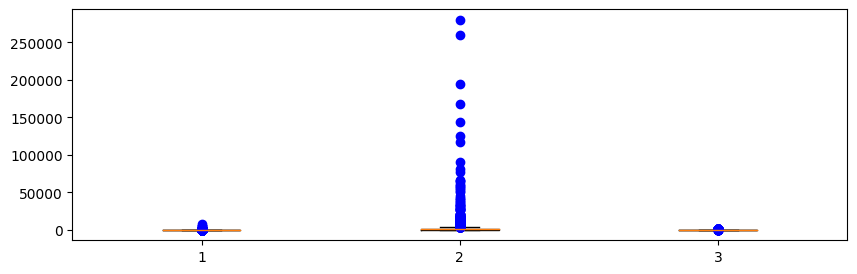

In [49]:
plt.figure(figsize=(10,3))
plt.boxplot( [customer_df['Freq'], customer_df['SaleAmount'], customer_df['ElapsedDays']],
            sym='bo')
plt.show()

In [50]:
# 파란색 점 sym='bo' 아웃레이어값이 많은 것이 데이터 값의 치우침을 알수 있음
customer_df['Freq_log'] = np.log1p(customer_df['Freq'])
customer_df['SaleAmount_log'] = np.log1p(customer_df['SaleAmount'])
customer_df['ElapsedDays_log'] = np.log1p(customer_df['ElapsedDays'])
customer_df.head()

,CustomerID,Freq,SaleAmount,ElapsedDays,Freq_log,SaleAmount_log,ElapsedDays_log
0,12346.0,1,77183.60,347,0.693147,11.253955,5.852202
1,12347.0,182,4310.00,24,5.209486,8.368925,3.218876
2,12348.0,31,1797.24,97,3.465736,7.494564,4.584967
3,12349.0,73,1757.55,40,4.304065,7.472245,3.713572
4,12350.0,17,334.40,332,2.890372,5.815324,5.808142


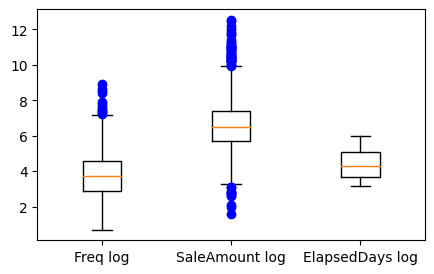

In [53]:
plt.figure(figsize=(5,3))
plt.boxplot( [customer_df['Freq_log'], customer_df['SaleAmount_log'], customer_df['ElapsedDays_log']],
            sym='bo')
plt.xticks([1,2,3],['Freq log','SaleAmount log','ElapsedDays log'])
plt.show()

In [55]:
# 분석 모델 구축 Kmeans   
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import StandardScaler

In [56]:
X_feature = customer_df.iloc[:,-3:]

In [58]:
X_feature_scaled = StandardScaler().fit_transform(X_feature)

In [68]:
# 최적의 k의 개수를 찾는 방법 
# 1 엘보우 방법
result = []
for i in range(1, 11):
    kmeans_i =  KMeans(n_clusters=i,random_state= 0,n_init=10) 
    kmeans_i.fit(X_feature_scaled) # 학습
    result.append(kmeans_i.inertia_)  # 왜곡 값

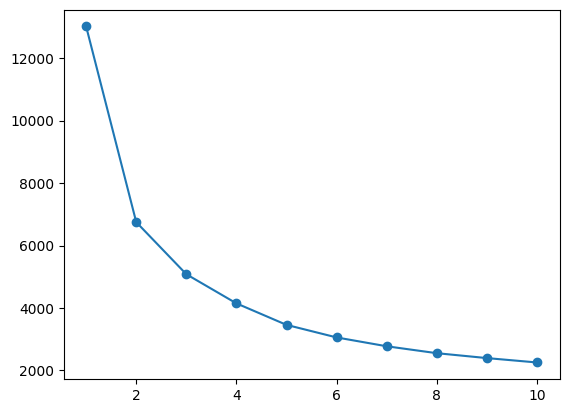

In [70]:
plt.plot(range(1,11),result, marker = 'o')
plt.show()

In [72]:
# 클러스터의 개수는 2나 또는 3개 적당
# k = 3 으로 해서 모델을 재 구축
kmeans = KMeans(n_clusters=3, random_state=0,n_init=10)
Y_labels =  kmeans.fit_predict(X_feature_scaled)

In [74]:
customer_df['ClusterLabel'] = Y_labels

In [75]:
customer_df.head()

,CustomerID,Freq,SaleAmount,ElapsedDays,Freq_log,SaleAmount_log,ElapsedDays_log,ClusterLabel
0,12346.0,1,77183.60,347,0.693147,11.253955,5.852202,1
1,12347.0,182,4310.00,24,5.209486,8.368925,3.218876,0
2,12348.0,31,1797.24,97,3.465736,7.494564,4.584967,2
3,12349.0,73,1757.55,40,4.304065,7.472245,3.713572,0
4,12350.0,17,334.40,332,2.890372,5.815324,5.808142,1


In [98]:
# 시각화를 제외하고 실루엣 계수만으로 판단할때
result = []
for i in range(2,11):
    kmeans = KMeans(n_clusters = i, random_state=0, n_init=10)
    Y_labels = kmeans.fit_predict(X_feature)
    silhouette_values =  silhouette_samples(X_feature,Y_labels)
    silhouette_avg =  np.mean(silhouette_values)
    result.append(silhouette_avg)

In [101]:
# np.argmax()  리스트중에서 가장 큰 값에 해당하는 인덱스를 반환하는 함수
np.argmax( result)+2
# 최적화된 클러스터 개수는 2 

2

In [83]:
# 실루엣 계수를 구하고 각 클러스터의 비중을  bar chart로 시각화 - 함수정의
from matplotlib import cm
def silhouetteViz(n_cluser, X_feature):
    kmeans = KMeans(n_clusters = n_cluser, random_state=0, n_init=10)
    Y_labels = kmeans.fit_predict(X_feature)
    silhouette_values =  silhouette_samples(X_feature,Y_labels)
    
    y_ax_lower, y_ax_upper = 0,0
    y_ticks = []
    
    for c in range(n_cluser):
        c_silhouettes =  silhouette_values[Y_labels == c]
        c_silhouettes.sort()
        y_ax_upper += len(c_silhouettes)
        color = cm.jet(float(c) / n_cluser)
        plt.barh( range(y_ax_lower, y_ax_upper), c_silhouettes, height=1.0, edgecolor='none',color=color)
        y_ticks.append( (y_ax_lower +  y_ax_upper) /2 )
        y_ax_lower += len(c_silhouettes)
        
        silhouette_avg =  np.mean(silhouette_values)
        plt.axvline(silhouette_avg, color = 'red', linestyle = '--')
        plt.title(f"Number of Cluser {n_cluser}  silhouette score {round(silhouette_avg,3)}")
    plt.show()    

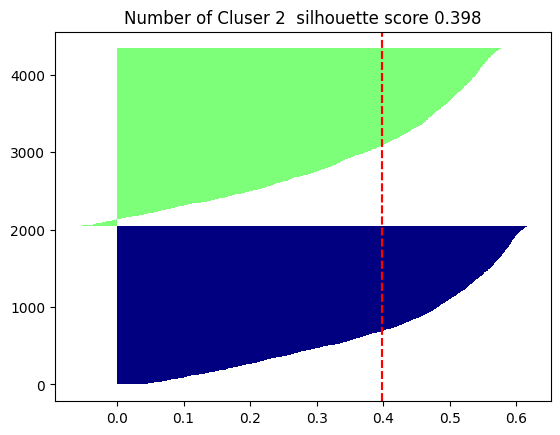

In [90]:
silhouetteViz(2,X_feature_scaled)

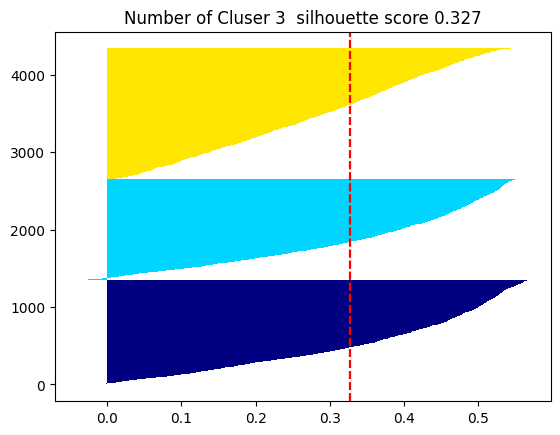

In [87]:
silhouetteViz(3,X_feature_scaled)

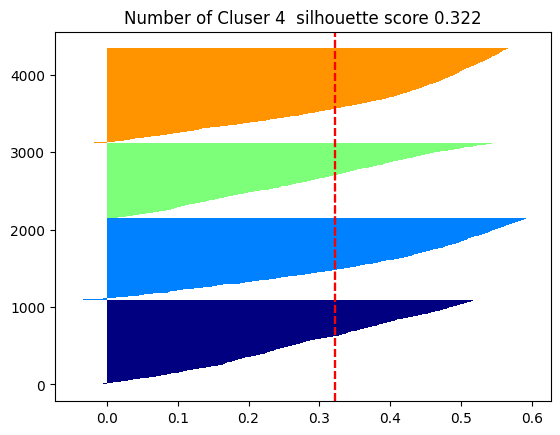

In [88]:
silhouetteViz(4,X_feature_scaled)

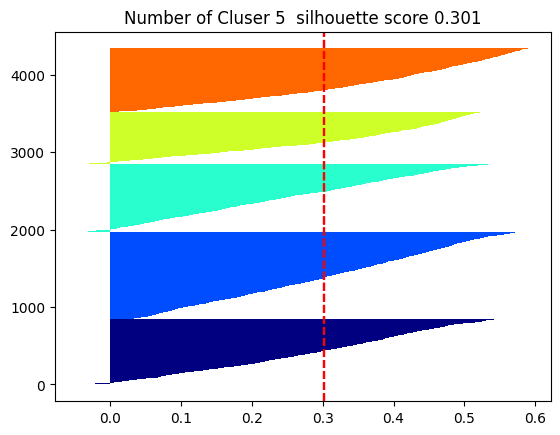

In [89]:
silhouetteViz(5,X_feature_scaled)

In [103]:
# 클러스터는 2개가 최적화 됨을 알수 있으므로 최종적으로 모델의 k 개수는 2개 
# 고객의 타입은 2가지로 분류 (구매횟수와 금액 그리고 최종 방문일을 기준으로 했을때)
kmeans = KMeans(n_clusters = 2, random_state=0, n_init=10)
Y_labels = kmeans.fit_predict(X_feature)
customer_df['ClusterLabel'] = Y_labels
customer_df.head()

,CustomerID,Freq,SaleAmount,ElapsedDays,Freq_log,SaleAmount_log,ElapsedDays_log,ClusterLabel
0,12346.0,1,77183.60,347,0.693147,11.253955,5.852202,1
1,12347.0,182,4310.00,24,5.209486,8.368925,3.218876,1
2,12348.0,31,1797.24,97,3.465736,7.494564,4.584967,1
3,12349.0,73,1757.55,40,4.304065,7.472245,3.713572,1
4,12350.0,17,334.40,332,2.890372,5.815324,5.808142,0


In [104]:
# 군집별 고객의수
grouped = customer_df.groupby(['ClusterLabel'])
grouped['CustomerID'].count()

ClusterLabel
0    2314
1    2024
Name: CustomerID, dtype: int64